In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


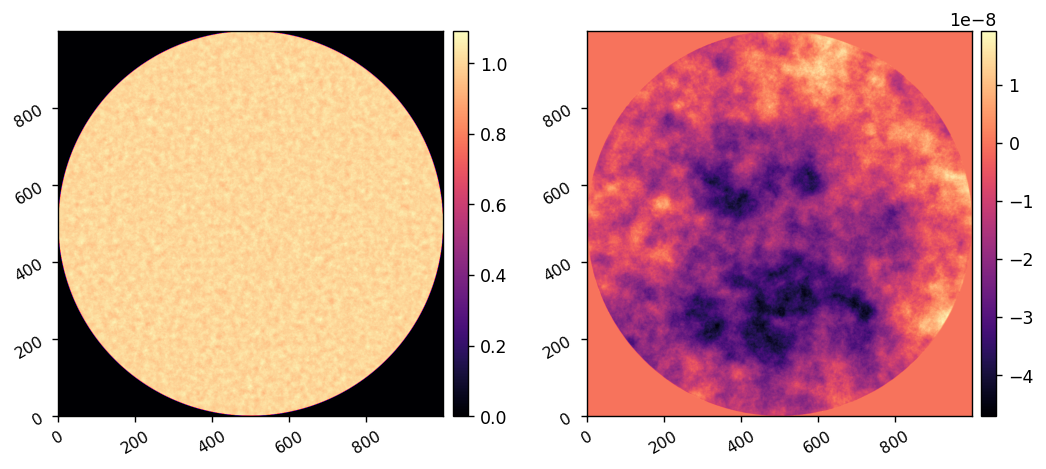

In [8]:
reload(fresnel)
reload(dm)
Nact = 96
npsf = 256

I = fresnel.CORO(
    Nact=Nact,
    npsf=npsf,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


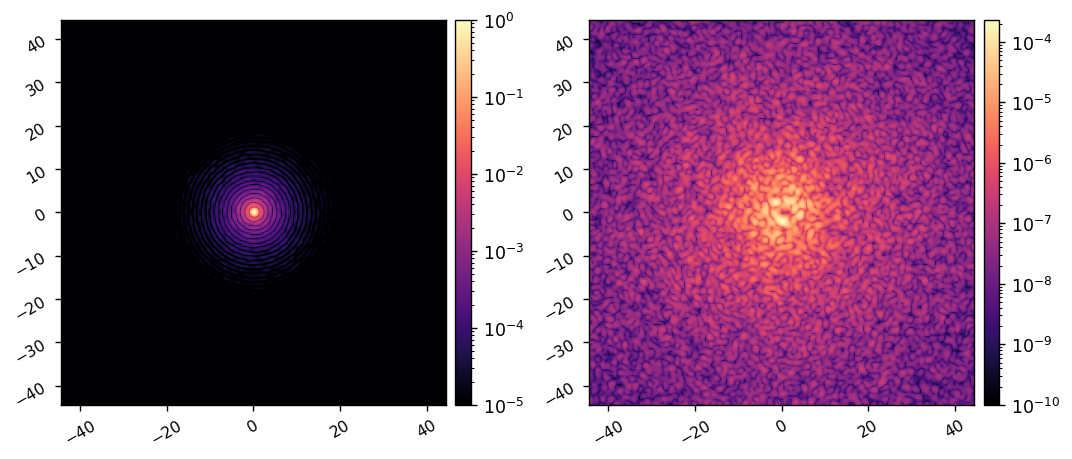

In [9]:
reload(fresnel)
reload(dm)

I = fresnel.CORO(
    Nact=Nact,
    npsf=npsf,
)
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(
    ref_psf, ref_coro_im,
    pxscl=I.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
)


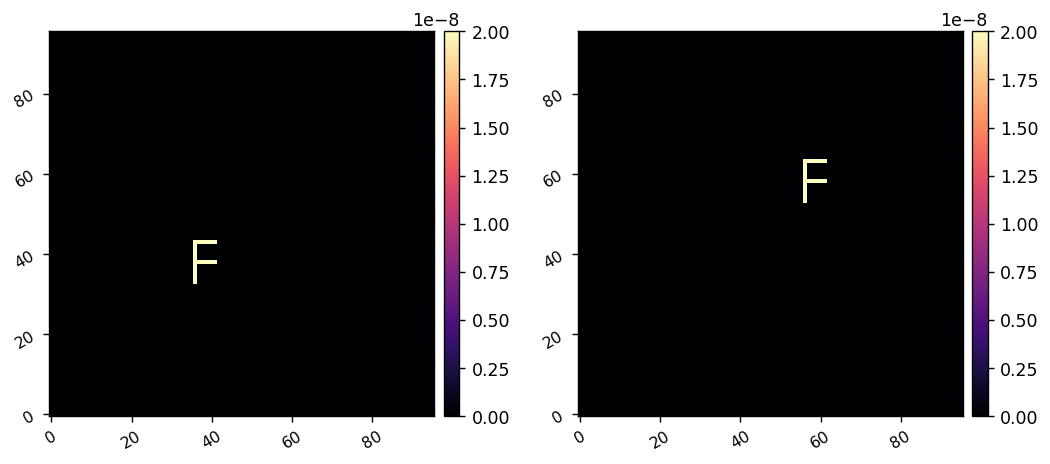

Propagating wavelength 0.000m.
PSF calculated in 0.387s


In [10]:
f1 = 20e-9 * utils.make_f(h=10, w=6, shift=(-10,-10), Nact=Nact)
f2 = 20e-9 * utils.make_f(h=10, w=6, shift=(10,10), Nact=Nact)
imshow2(f1, f2)

I.set_dm1(f1)
I.set_dm2(f2)
wfs = I.calc_wfs()
I.reset_dms()

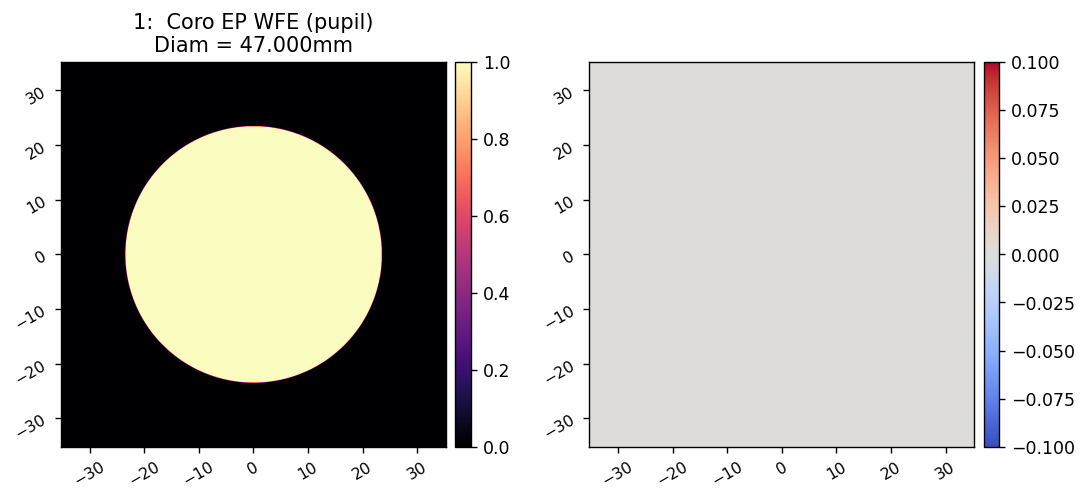

Focal Plane Correction:  -1.754548928367683e-05 mm


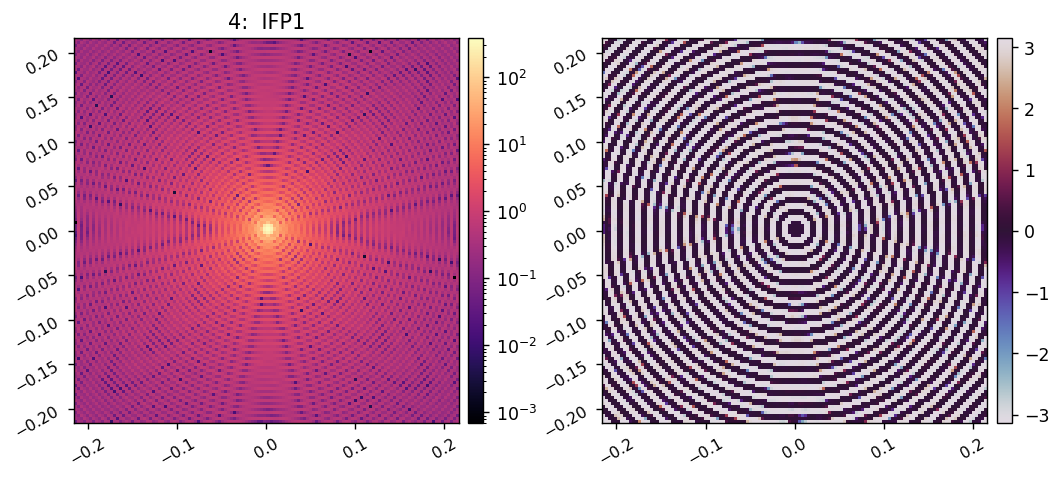

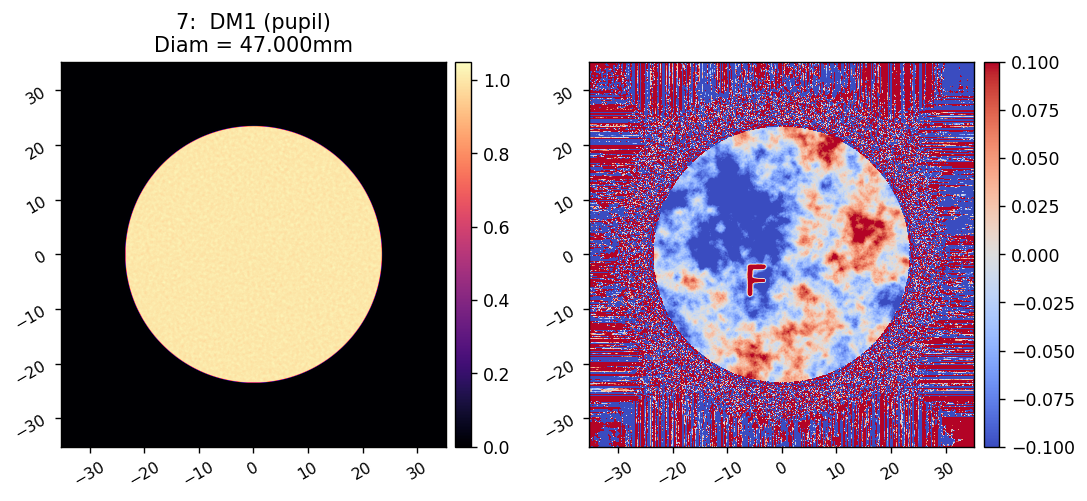

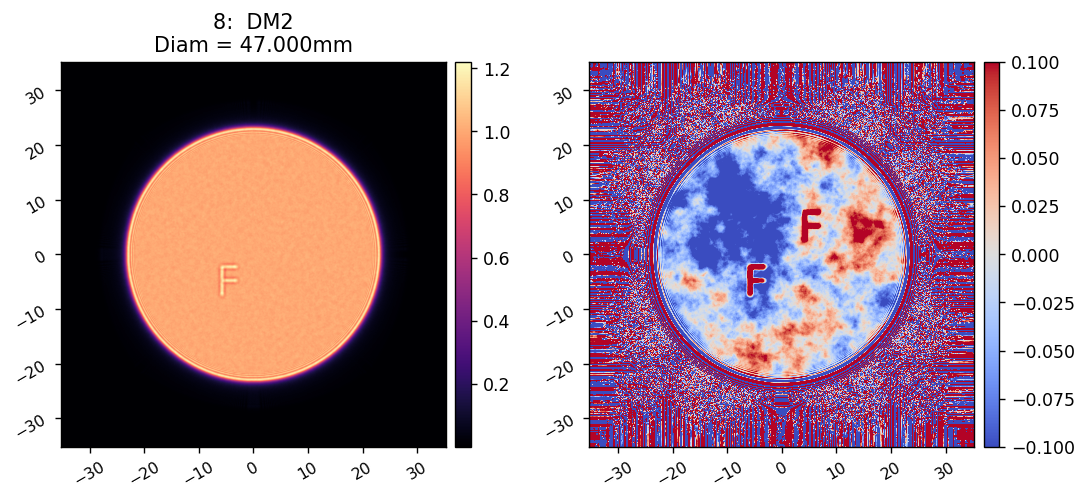

Focal Plane Correction:  -0.0001403638902885973 mm


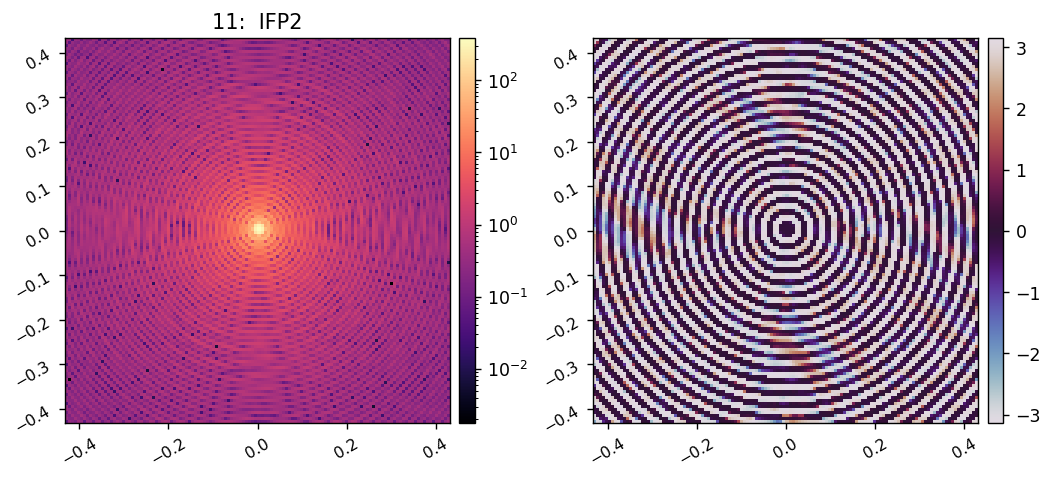

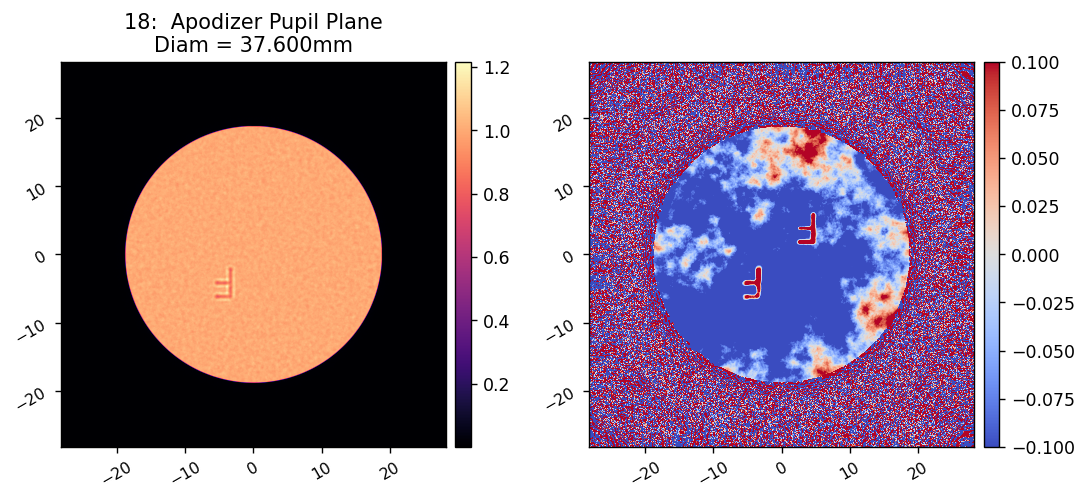

Focal Plane Correction:  -0.00017545484620740126 mm


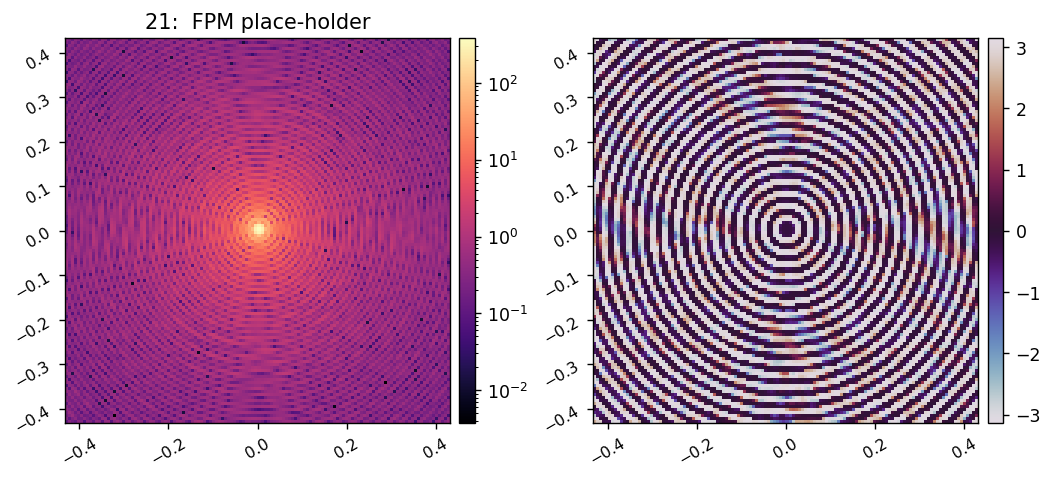

Focal Plane Correction:  -0.00017545484620740126 mm


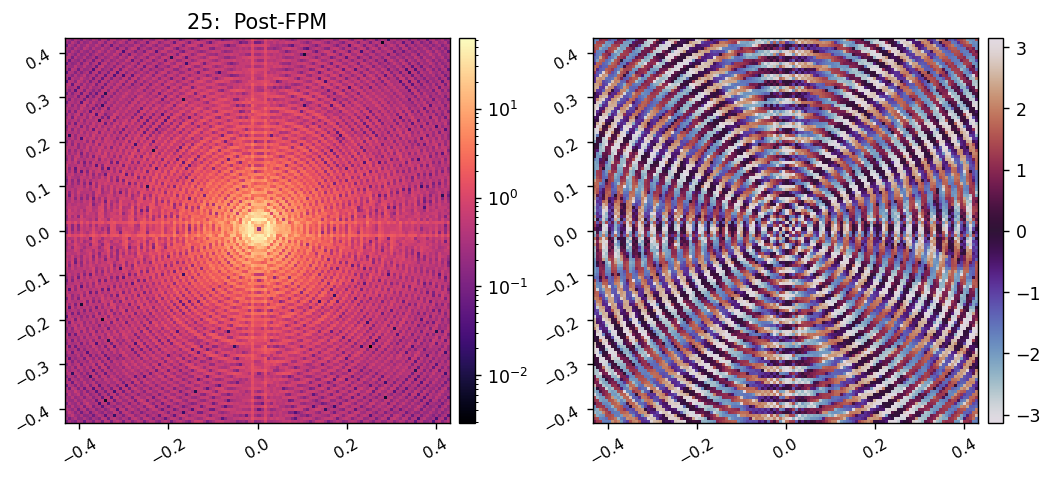

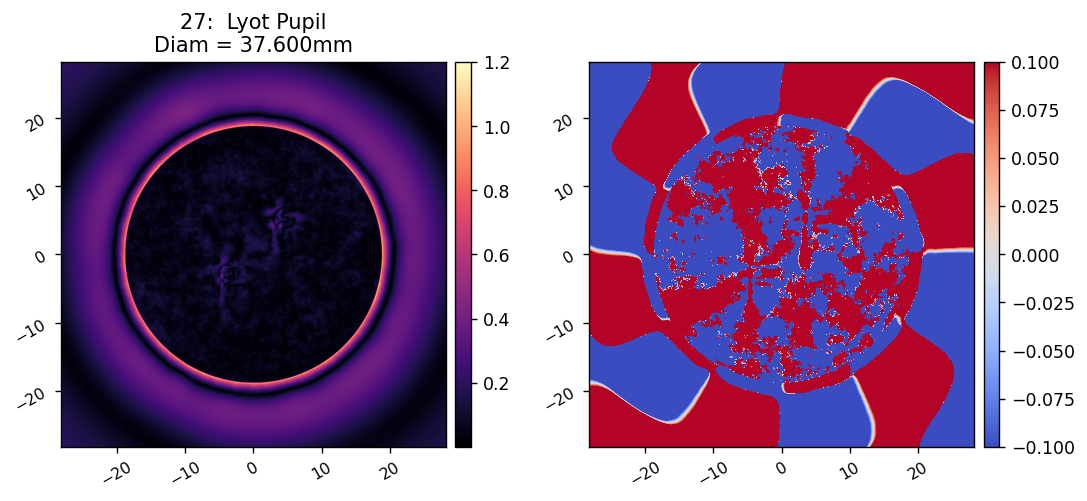

Focal Plane Correction:  -4.283565857576832e-05 mm


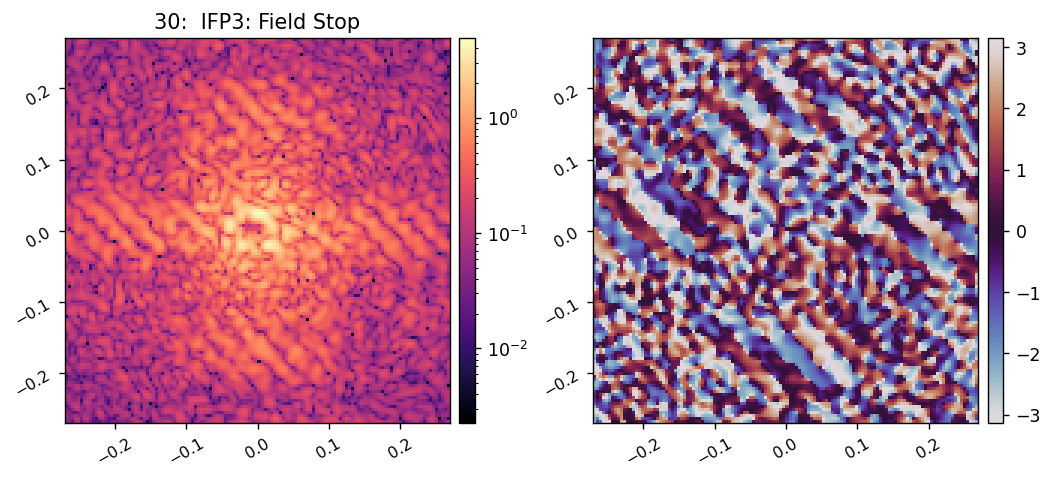

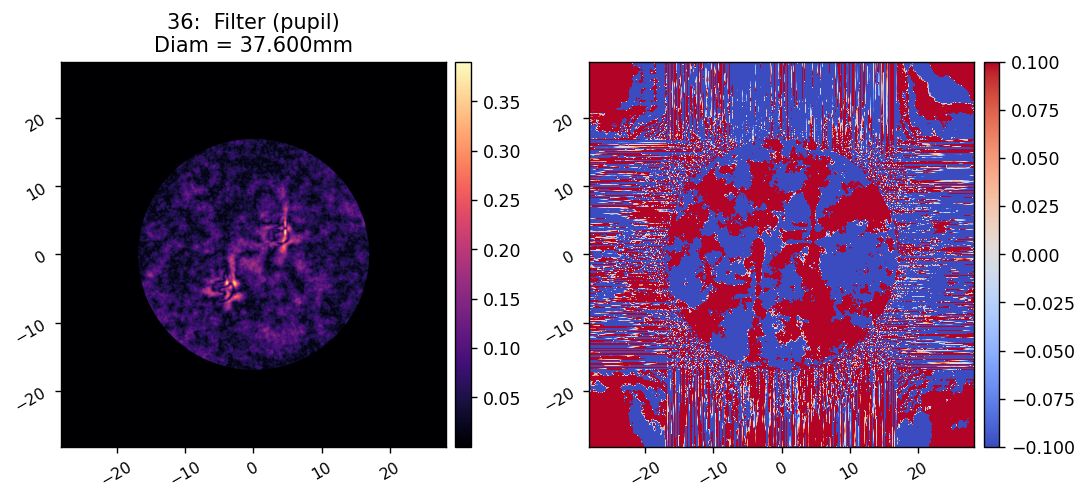

Focal Plane Correction:  -0.00014457032726511443 mm


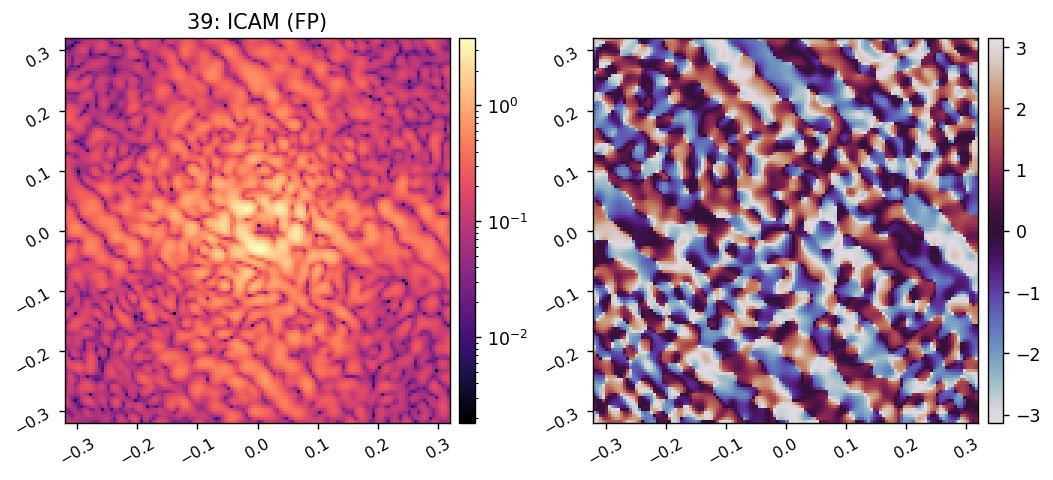

In [11]:
for i,wf in enumerate(wfs):
    if 'fp' in wf.location.lower():
        f_corr = wf.z_w0 - wf.z
        print('Focal Plane Correction: ', f_corr.to(u.mm))
        pxscl_mm = wf.pixelscale.to_value(u.mm/u.pix)
        imshow2(
            wf.amplitude, wf.phase, 
            f'{i:d}: '+wf.location[5:], 
            pxscl=pxscl_mm, 
            npix=128, 
            lognorm1=True, 
            cmap2='twilight',
        )
    elif 'pupil' in wf.location.lower() or 'dm' in wf.location.lower():
        imshow2(
            wf.amplitude, wf.phase, 
            f'{i:d}: '+wf.location[5:] + f'\nDiam = {2*wf.spot_radius().to_value(u.mm):.3f}mm', 
            pxscl=wf.pixelscale.to(u.mm/u.pix), 
            npix=1.5*I.npix, 
            vmin2=-0.1, vmax2=0.1, 
            # vmin2=-0.01, vmax2=0.01, 
            cmap2='coolwarm',
        )

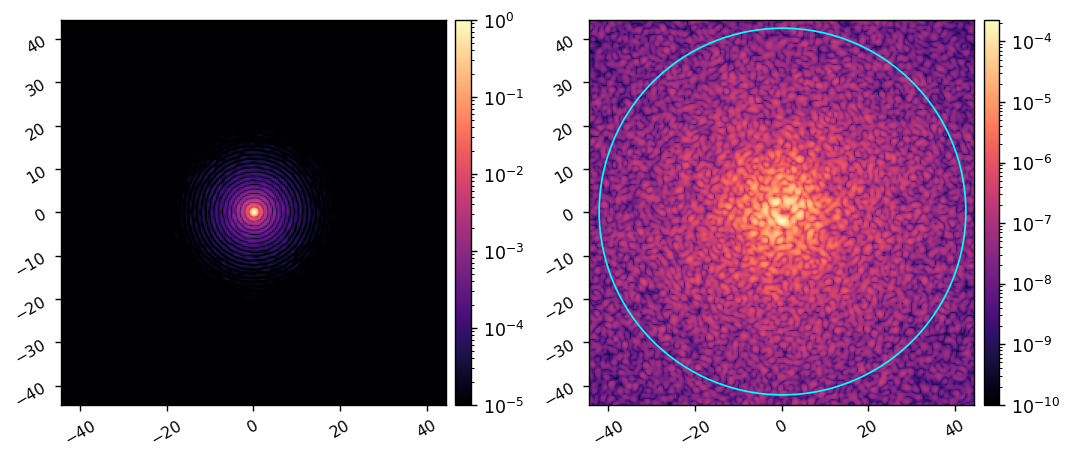

42.300000000000004

In [12]:
reload(fraunhofer)
M = fraunhofer.MODEL(
    Nact=Nact,
    npsf=npsf,
)
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(
    model_psf, model_coro_im,
    pxscl=M.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
    patches2=[Circle((M.psf_pixelscale_lamDc/2,M.psf_pixelscale_lamDc/2), M.control_rad, fill=False, color='cyan')]
)
M.control_rad

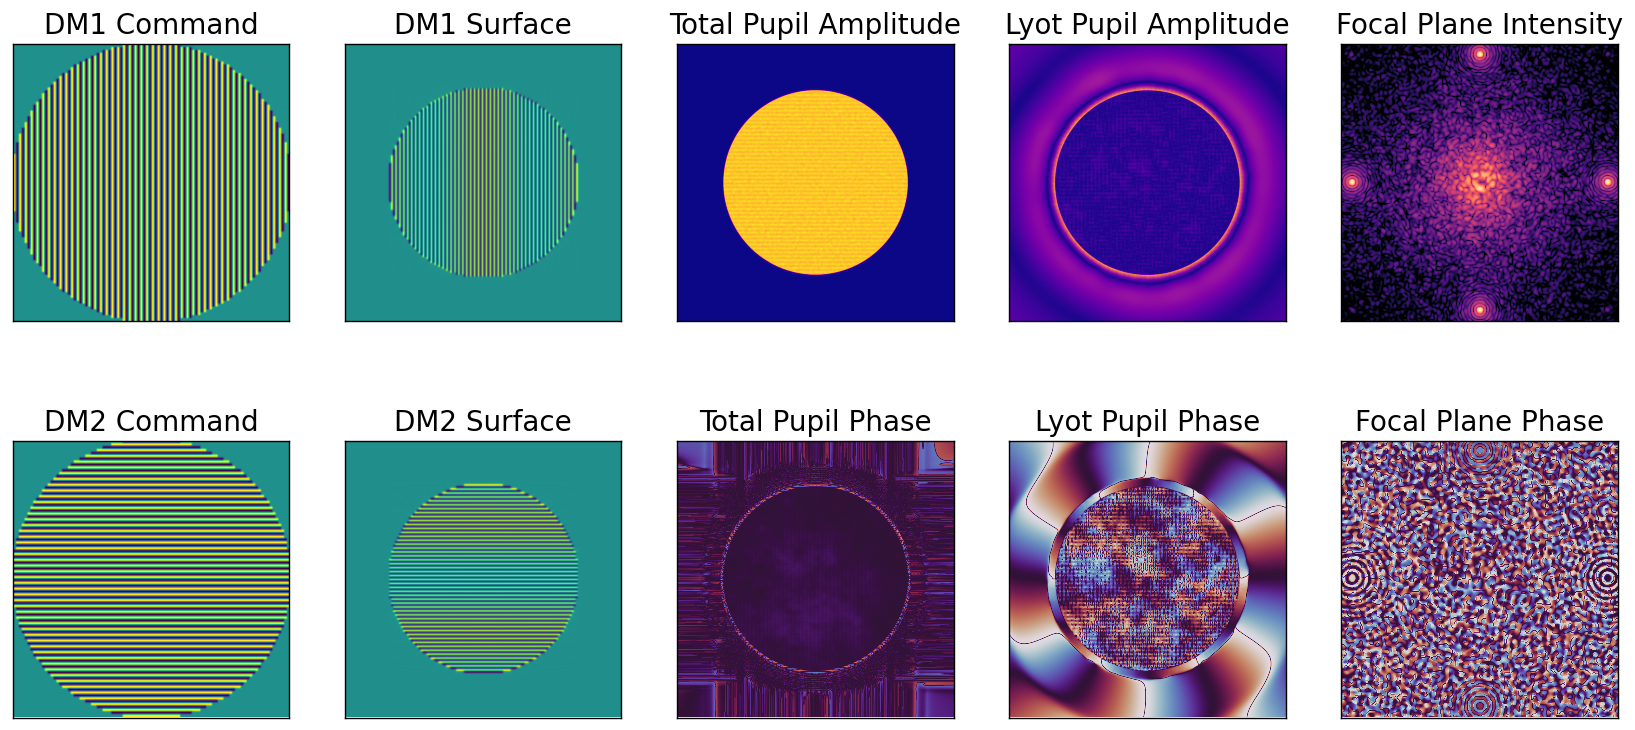

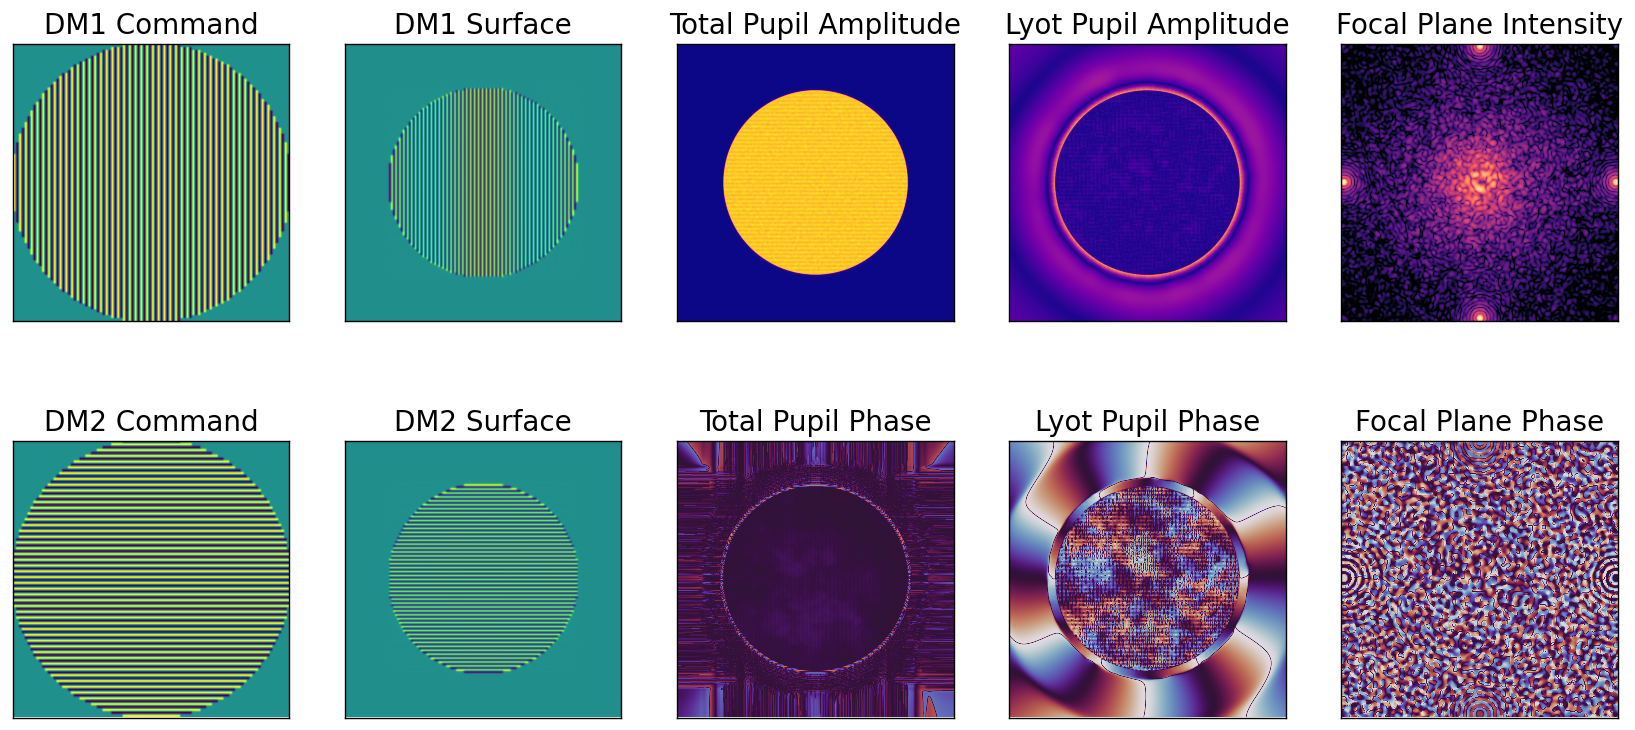

In [13]:
dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )

dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=Nact/2, y_cpa=0, Nact=M.Nact)
dm2_command = 2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=Nact/2, Nact=M.Nact)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf_1 = M.forward(acts, 630e-9, use_vortex=1, fancy_plot=1)
fpwf_2 = M.forward(acts, 670e-9, use_vortex=1, fancy_plot=1)